In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import re
import pickle
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [53]:
data = pd.read_csv(r"/content/amazon_alexa.tsv", delimiter = '\t', quoting = 3)
print(f"Dataset shape: {data.shape}")

Dataset shape: (3150, 5)


In [54]:
data.head(5)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [55]:
data.columns.values

array(['rating', 'date', 'variation', 'verified_reviews', 'feedback'],
      dtype=object)

In [56]:
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [57]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [58]:
#dropping the null record
data.dropna(inplace=True)

In [59]:
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,0
feedback,0


In [60]:
data.shape

(3149, 5)

In [61]:
data['length'] = data['verified_reviews'].apply(len)

In [62]:
data.head(2)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9


In [63]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


In [64]:
data['rating'].value_counts()

,count
rating,
5,2286
4,455
1,161
3,152
2,95


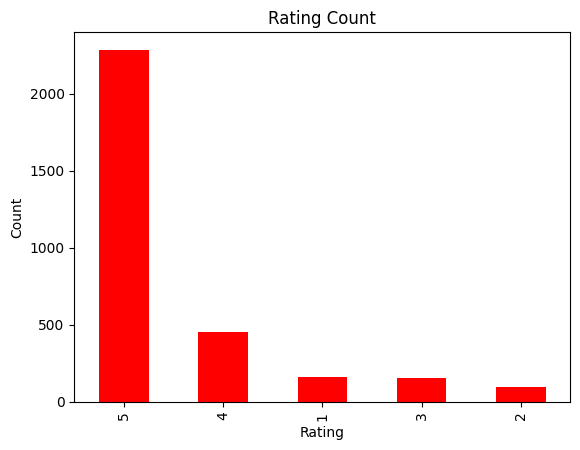

In [65]:
#Plotting a bar graph to visualize
data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating Count')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [66]:
round(data['rating'].value_counts()/len(data)*100,2)

,count
rating,
5,72.59
4,14.45
1,5.11
3,4.83
2,3.02


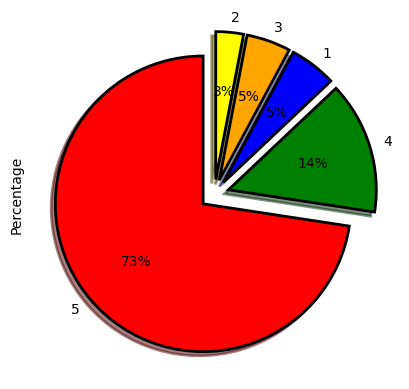

In [67]:
#Plotting a Pie Chart for visualization
colors = ('red','green','blue','orange','yellow')
wp = {'linewidth':2,'edgecolor':'black'}
tags = data['rating'].value_counts()
explode = (0.1,0.1,0.1,0.1,0.1)
tags.plot(kind = 'pie', autopct = '%1.0f%%', shadow = True, colors = colors, startangle = 90, wedgeprops = wp, explode = explode,label='Percentage')
from io import BytesIO
graph = BytesIO()


In [68]:
data['feedback'].value_counts()

,count
feedback,
1,2893
0,256


In [69]:
review_0 = data[data['feedback']==0].iloc[1]['verified_reviews']
review_0

'Sound is terrible if u want good music too get a bose'

In [70]:
review_1 = data[data['feedback']==1].iloc[1]['verified_reviews']
review_1

'Loved it!'

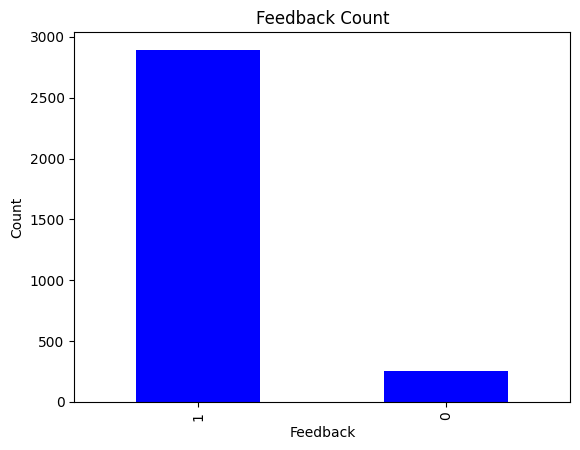

In [71]:
#Bar graph to visualize the total count of each feedback
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback Count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [72]:
print(f"Feedback in percentage distribution:",round(data['feedback'].value_counts()/len(data)*100,2))

Feedback in percentage distribution: feedback
1    91.87
0     8.13
Name: count, dtype: float64


In [73]:
#Feedback ratings lies in which rate
data[data['feedback']==0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [74]:
data[data['feedback']==1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


In [75]:
data['variation'].value_counts() # Different Product with feedback count

,count
variation,
Black Dot,516
Charcoal Fabric,430
Configuration: Fire TV Stick,350
Black Plus,270
Black Show,265
Black,261
Black Spot,241
White Dot,184
Heather Gray Fabric,157


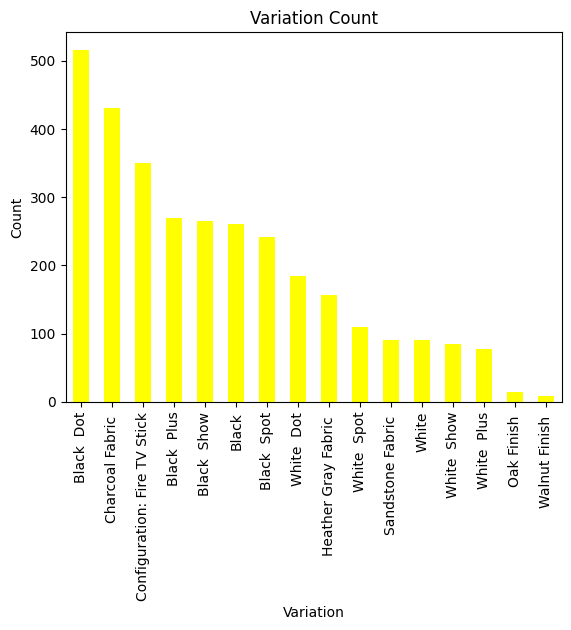

In [76]:
#Bar graph to visualize the total counts of each variation
data['variation'].value_counts().plot.bar(color='yellow')
plt.title('Variation Count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [77]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


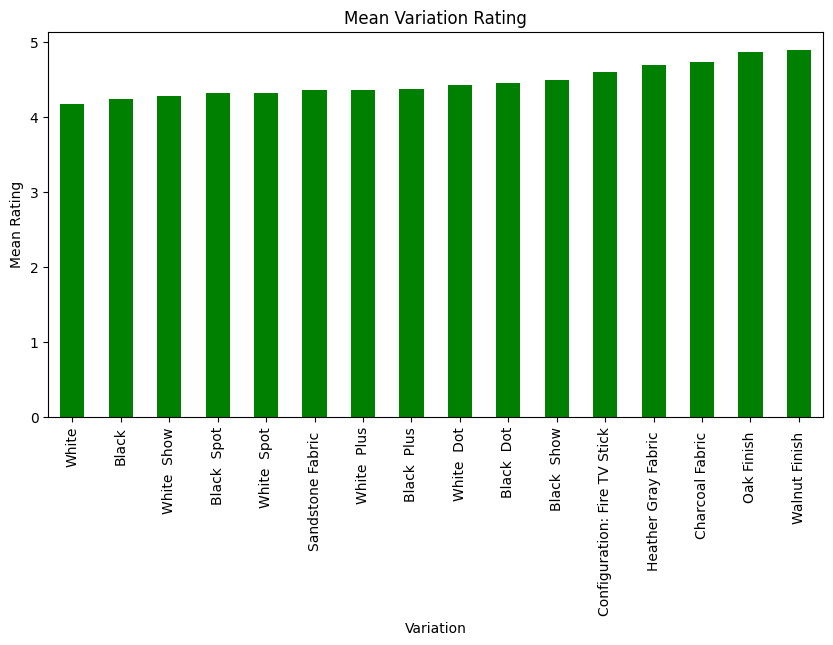

In [78]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='green',figsize=(10,5))
plt.title('Mean Variation Rating')
plt.xlabel('Variation')
plt.ylabel('Mean Rating')
plt.show()

In [79]:
data['length'].describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


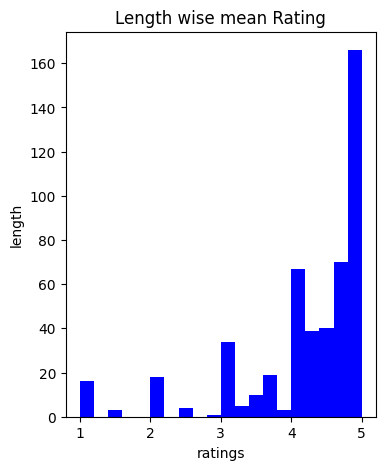

In [80]:
data.groupby('length')['rating'].mean().plot.hist(color = "blue",figsize=(4,5),bins=20)
plt.title('Length wise mean Rating')
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [81]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['verified_reviews'])

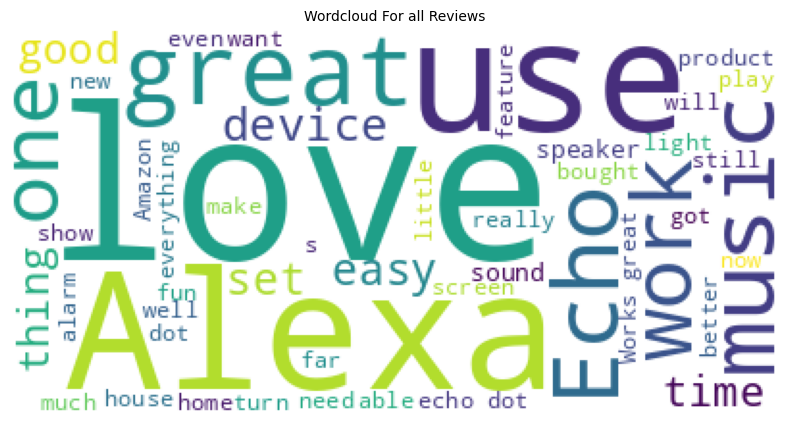

In [82]:
#Word cloud generation
reviews = " ".join([review for review in data['verified_reviews']])
wc = WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(10,5))
plt.imshow(wc.generate(reviews))
plt.title("Wordcloud For all Reviews",fontsize=10)
plt.axis('off')
plt.show()

In [83]:
corpus = []
stemmer = PorterStemmer()
for i in range(0,data.shape[0]):
  review = re.sub('[^a-zA-Z]',' ',data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [84]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [85]:
import os
if not os.path.exists('Models'):
    os.makedirs('Models')
pickle.dump(cv,open("Models/countVectorizer.pkl","wb"))

In [86]:
X.shape

(3149, 2500)

In [87]:
y.shape

(3149,)

In [88]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=15)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2519, 2500), (630, 2500), (2519,), (630,))

In [89]:
scaler = MinMaxScaler()
X_train_sc1 = scaler.fit_transform(X_train)
X_test_sc1 = scaler.transform(X_test)

In [90]:
pickle.dump(scaler,open("Models/scaler.pkl","wb"))

In [92]:
#Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(X_train_sc1,y_train)

RandomForestClassifier()

In [93]:
#Accuracy on training and testing
model_rf.score(X_train_sc1,y_train),model_rf.score(X_test_sc1,y_test)

(0.9948392219134577, 0.9476190476190476)

In [100]:
y_preds = model_rf.predict(X_test_sc1)

In [95]:
cm = confusion_matrix(y_test,y_preds)
cm

array([[ 23,  30],
       [  3, 574]])

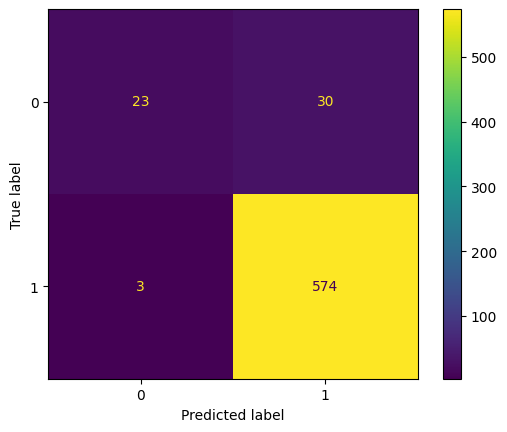

In [97]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()